Ref.: Wirth paper, pages 4 & 5.

Since the simulation is done on a rectangle, say $[0,a]\times[0,b]$, with periodic conditions on the edges, we can calculate the bidimensional Fourier series (DFT):
$$\theta'_{tp}(\vec x)=\frac1{ab}\sum_{m,n}\hat{\theta}_{tp}(\vec k_{m,n})e^{i\vec k_{m,n}\cdot\vec x}$$
where $\vec k_{m,n}=\left(\frac{2\pi m}a,\frac{2\pi n}b\right)$ and
$$\hat{\theta}_{tp}(\vec k_{m,n})=\int_0^a\int_0^b \theta'_{tp}(\vec x)e^{-i\vec k_{m,n}\cdot\vec x}\mathrm dy\mathrm dx$$

Given the Python representation of the DFT, here the indices $m,n$ move from $0,0$ to $P_a,P_b$.

Commented blocks are test cases.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from spectral import geostwind, vertwind

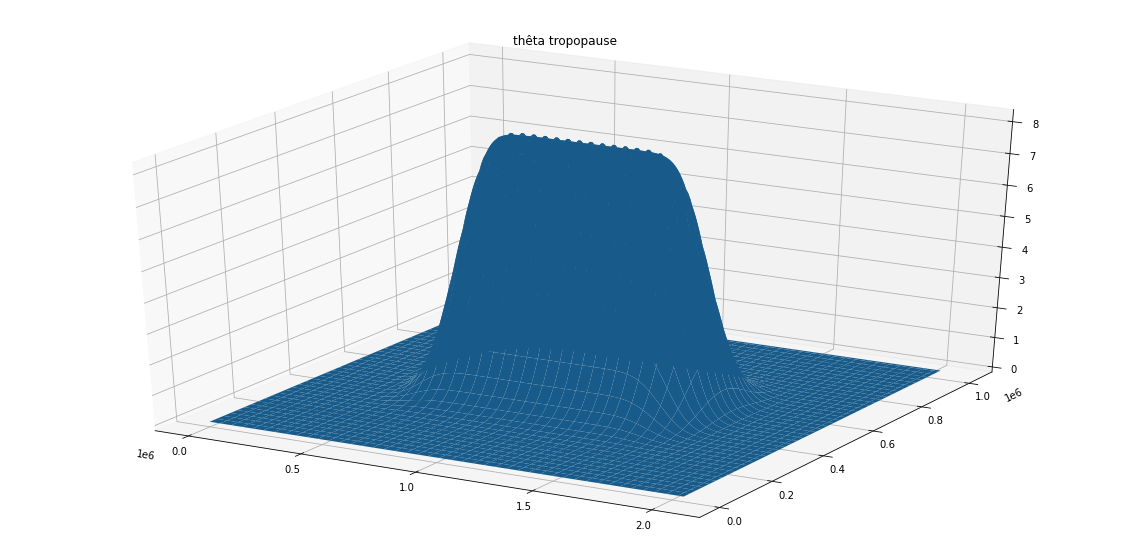

In [2]:
# Initial data
a, b = 1024e3, 2048e3
Pa, Pb = 128, 256 # samples

# pseudo-filament
thetatp = np.zeros((Pa,Pb))
import scipy.ndimage as spnd 
Px = 8 
Py = 64
thetaanom = 15
for i in range(Pa): 
    for j in range(Pb):
        if abs(i-Pa/2) < Px and abs(j-Pb/2) < Py:
            thetatp[i,j] = thetaanom
spnd.gaussian_filter(thetatp, 10, output=thetatp)

plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(np.linspace(0,b,Pb), np.linspace(0,a,Pa))
ax.plot_surface(X,Y,thetatp)
plt.title("thêta tropopause")
plt.show()

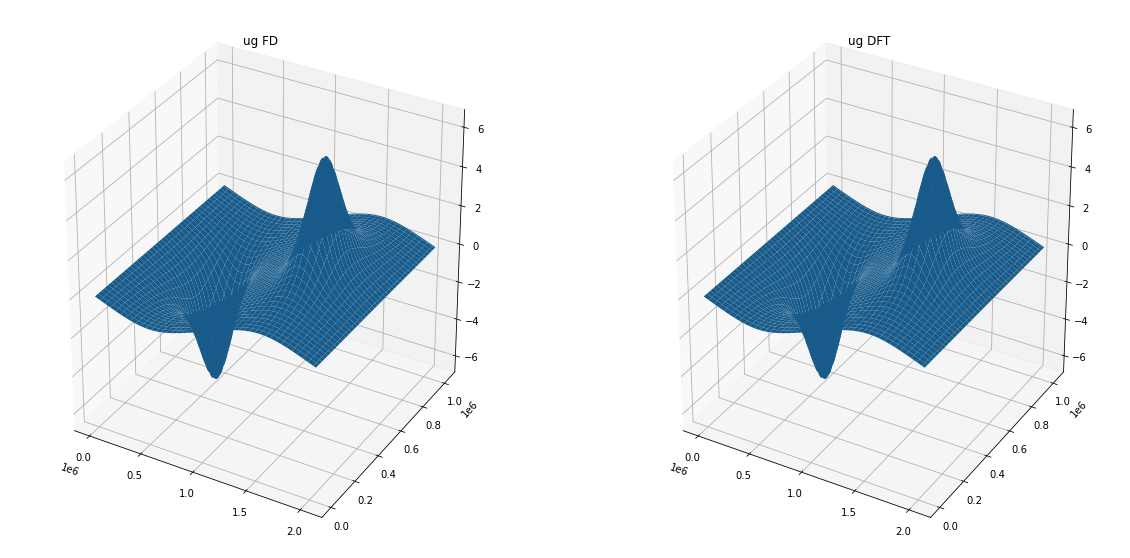

L2 difference (relative) : 0.0005178868709926133
Linf difference (relative) : 0.0008831061713919054


In [3]:
# main script
ug,vg = geostwind(a,b,thetatp)
ug2,vg2 = geostwind(a,b,thetatp,fourier=True)

fig = plt.figure()
ax = plt.subplot(1,2,1,projection='3d')
ax.set_title("ug FD")
ax.plot_surface(X,Y,ug)
ax = plt.subplot(1,2,2,projection='3d')
ax.set_title("ug DFT")
ax.plot_surface(X,Y,ug2)
plt.show()

print("L2 difference (relative) : %s" % (np.linalg.norm(ug-ug2)/np.linalg.norm(ug)))
print("Linf difference (relative) : %s" % (np.max(np.abs(ug-ug2))/np.max(np.abs(ug))))

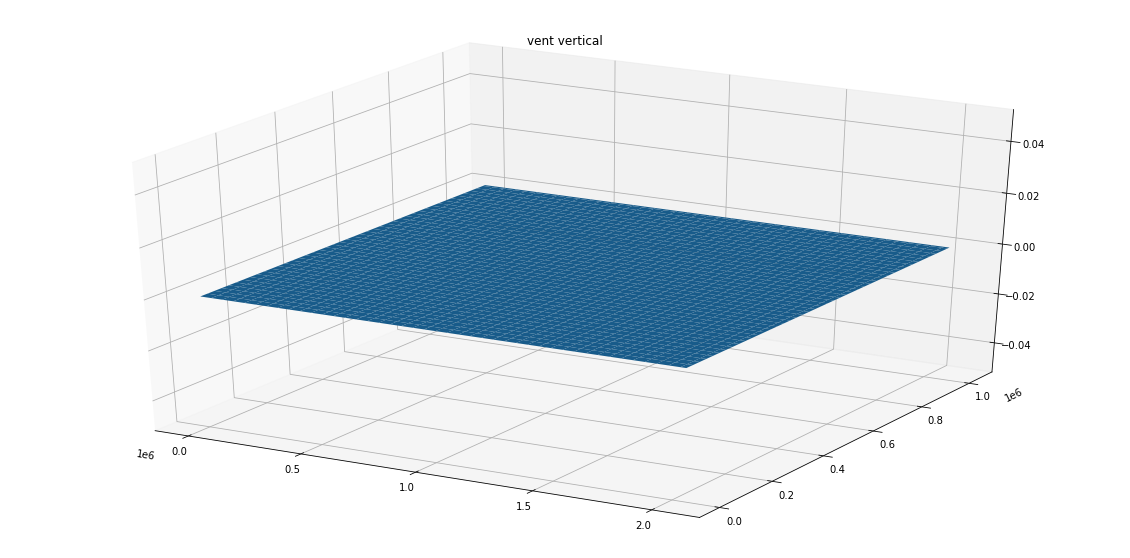

In [4]:
w = vertwind(a,b,thetatp,thetatp,1)

plt.figure()
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(np.linspace(0,b,Pb), np.linspace(0,a,Pa))
ax.plot_surface(X,Y,w)
plt.title("vent vertical")
plt.show()